Using device: cuda
Training on times: [15.0, 30.0, 45.0] seconds
Predicting time: 60.0 seconds
Input tensor shape: torch.Size([1, 12, 256, 256])
Target tensor shape: torch.Size([1, 4, 256, 256])


/tmp/ipykernel_36/2048772258.py:150: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')


Total parameters in Multi-Variable FNO: 33,593,412

Starting Multi-Variable FNO training with corrected physics and normalization...
Epoch 0/2000 | Total: 134.070496 | Physics: 0.716118 | BC: 0.136540 | Data: 12.652671 | LR: 0.000040
Epoch 100/2000 | Total: 30.103268 | Physics: 0.706890 | BC: 0.084519 | Data: 2.516462 | LR: 0.000531
Epoch 200/2000 | Total: 5.268552 | Physics: 0.898130 | BC: 0.077718 | Data: 0.046713 | LR: 0.001000
Epoch 300/2000 | Total: 5.235173 | Physics: 0.856401 | BC: 0.078050 | Data: 0.045878 | LR: 0.000992
Epoch 400/2000 | Total: 5.293397 | Physics: 0.838765 | BC: 0.077425 | Data: 0.056595 | LR: 0.000969
Epoch 500/2000 | Total: 5.209023 | Physics: 0.838776 | BC: 0.077682 | Data: 0.046862 | LR: 0.000932
Epoch 600/2000 | Total: 5.200018 | Physics: 0.858577 | BC: 0.077128 | Data: 0.046749 | LR: 0.000882
Epoch 700/2000 | Total: 5.193796 | Physics: 0.849987 | BC: 0.077225 | Data: 0.046498 | LR: 0.000820
Epoch 800/2000 | Total: 5.192196 | Physics: 0.847269 | BC: 0.0773

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


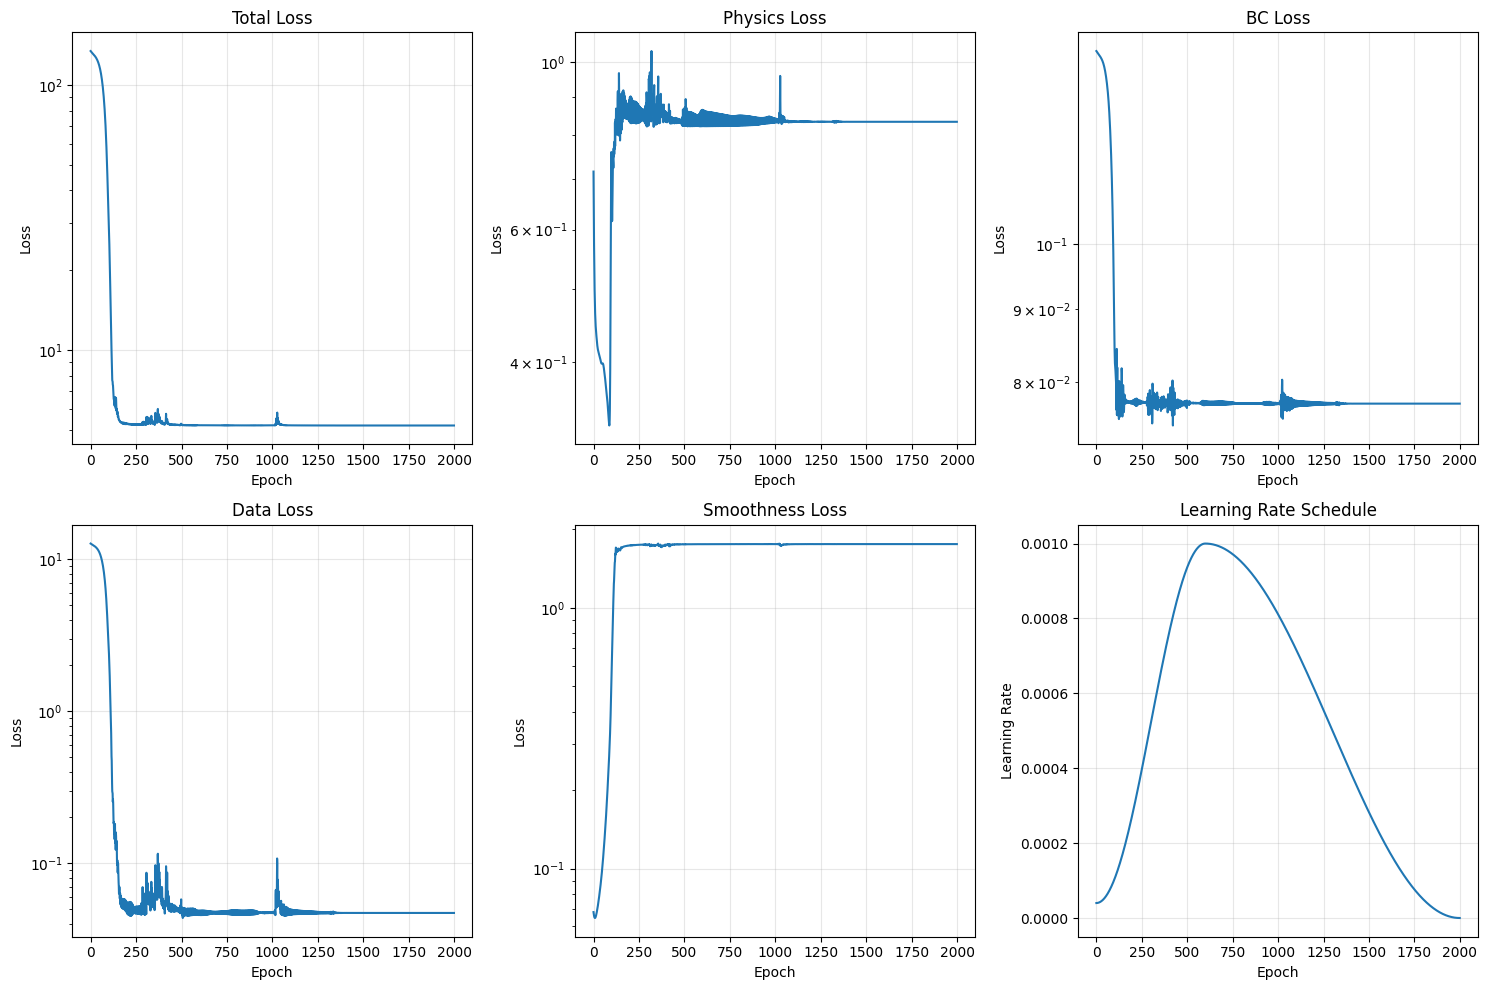

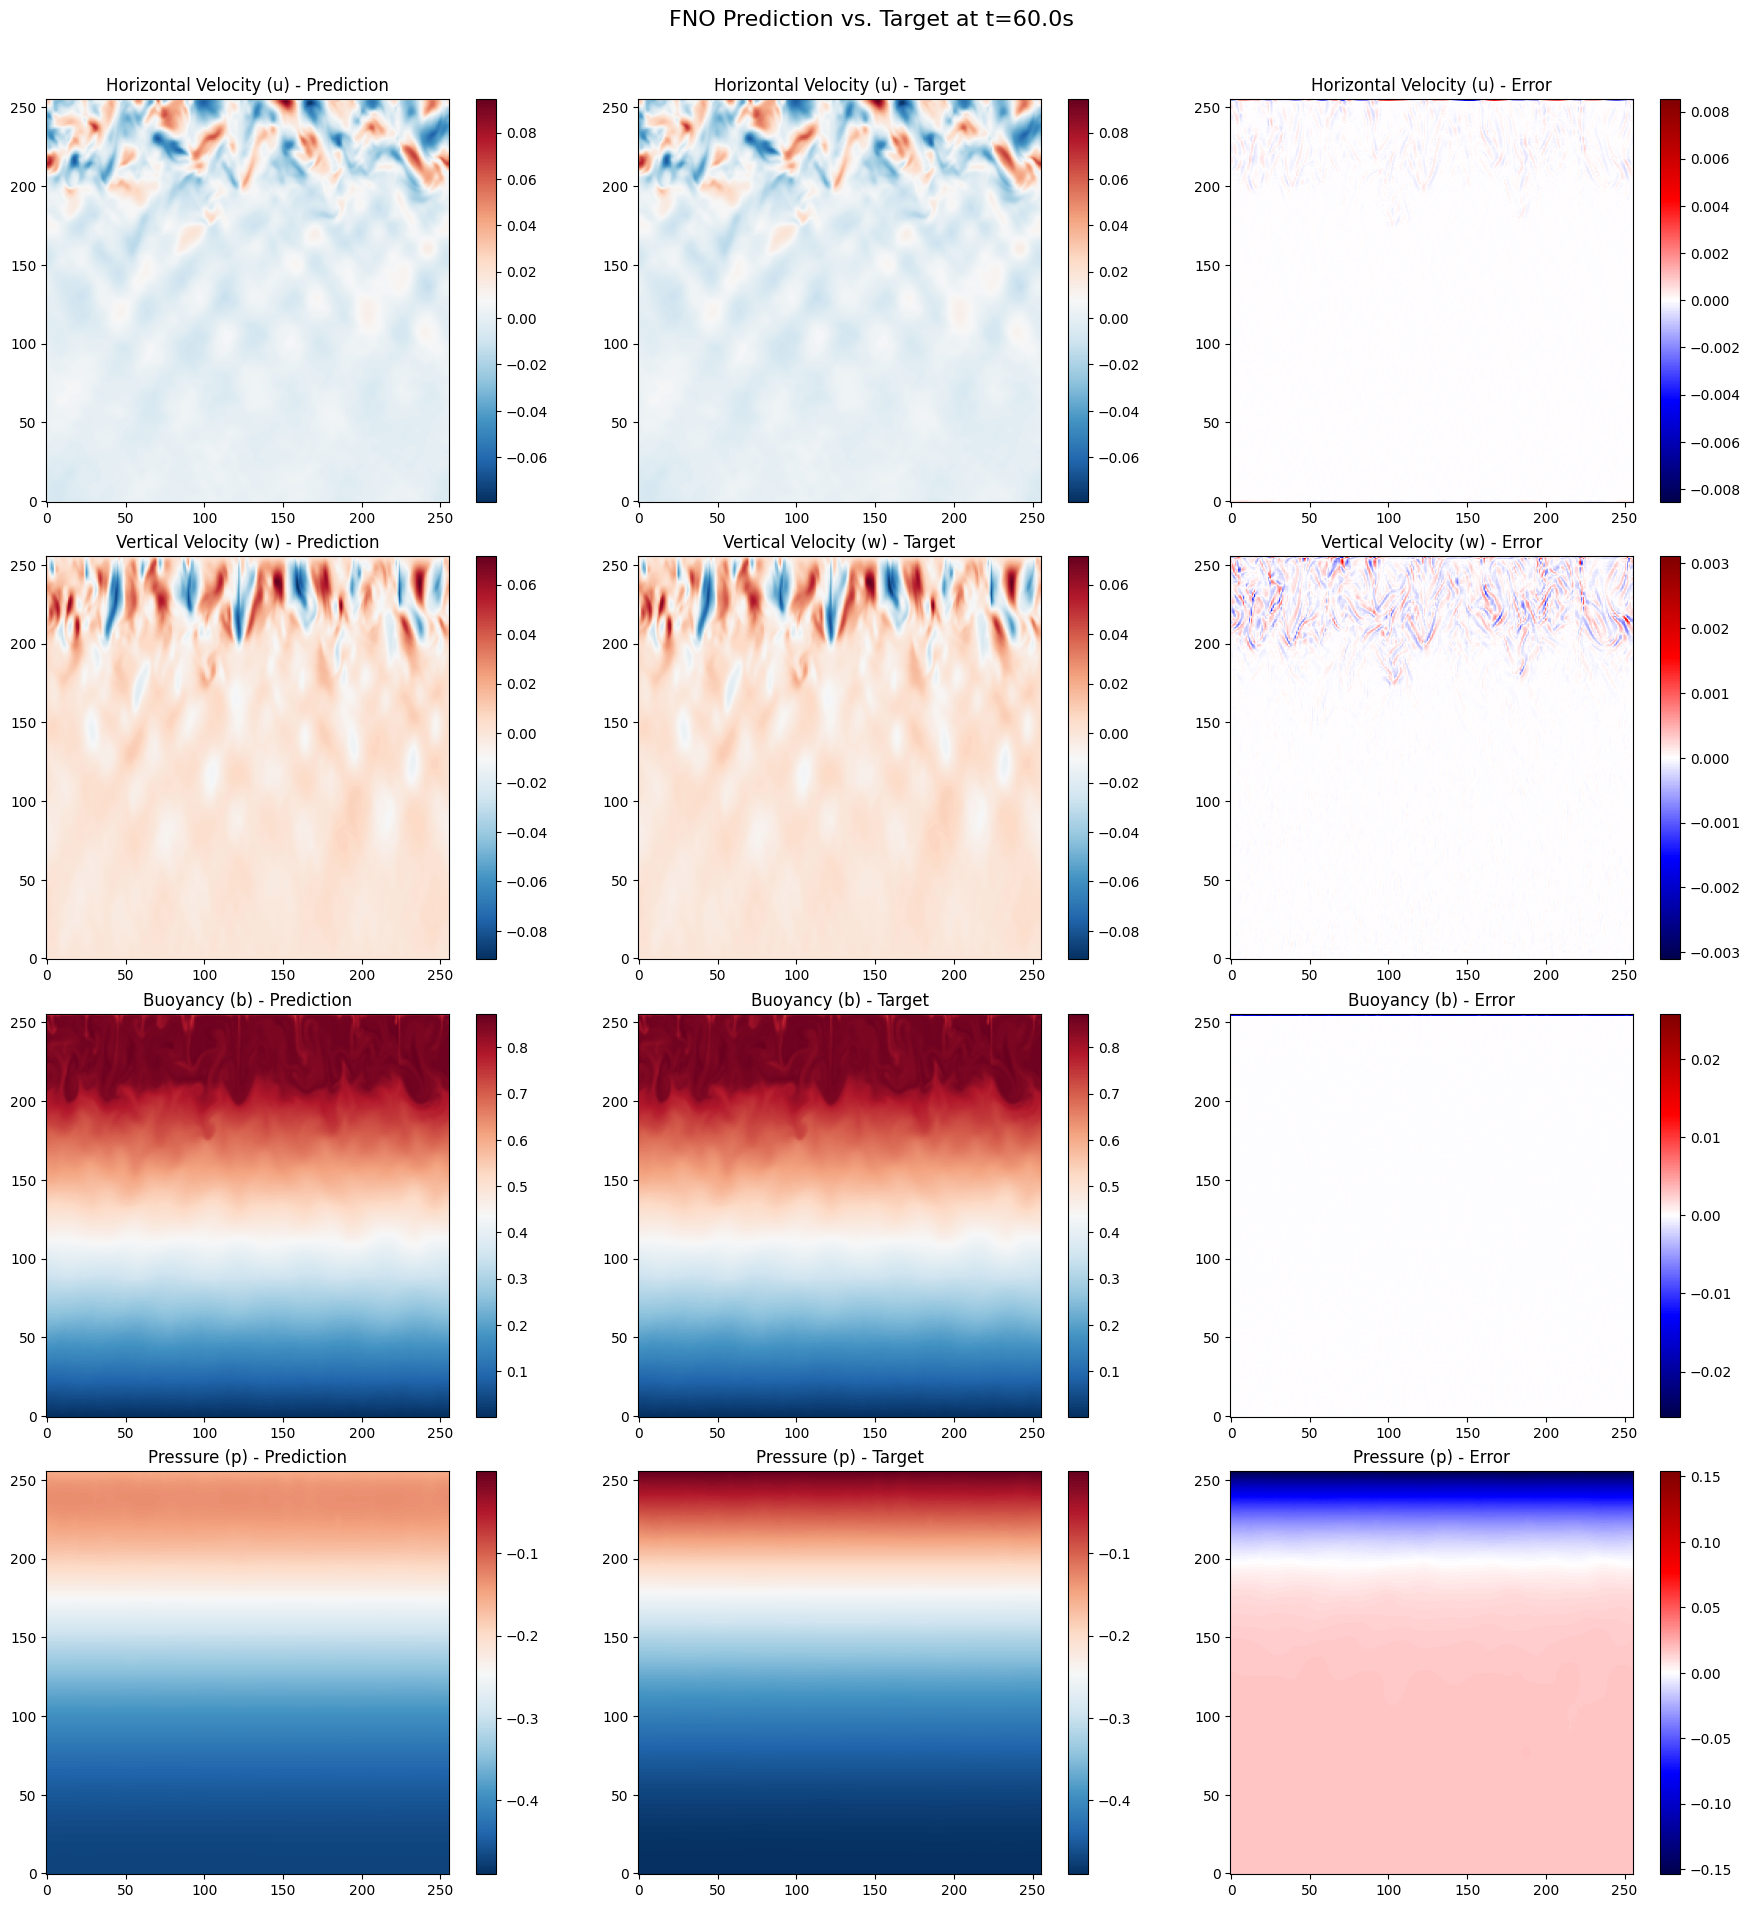


Error Metrics for All Variables:
--------------------------------------------------

Horizontal Velocity (u):
  MSE: 0.000000
  MAE: 0.000044
  Max Error: 0.008539
  Relative Error: 3.3679%

Vertical Velocity (w):
  MSE: 0.000000
  MAE: 0.000050
  Max Error: 0.003107
  Relative Error: 9.3782%

Buoyancy (b):
  MSE: 0.000002
  MAE: 0.000105
  Max Error: 0.025778
  Relative Error: 0.0478%

Pressure (p):
  MSE: 0.001263
  MAE: 0.024079
  Max Error: 0.153880
  Relative Error: 87.1334%

Integral Quantities:
--------------------------------------------------
Kinetic Energy - Predicted: 0.000143, Target: 0.000144, Error: 0.38%
Enstrophy      - Predicted: 0.400347, Target: 0.399034, Error: 0.33%


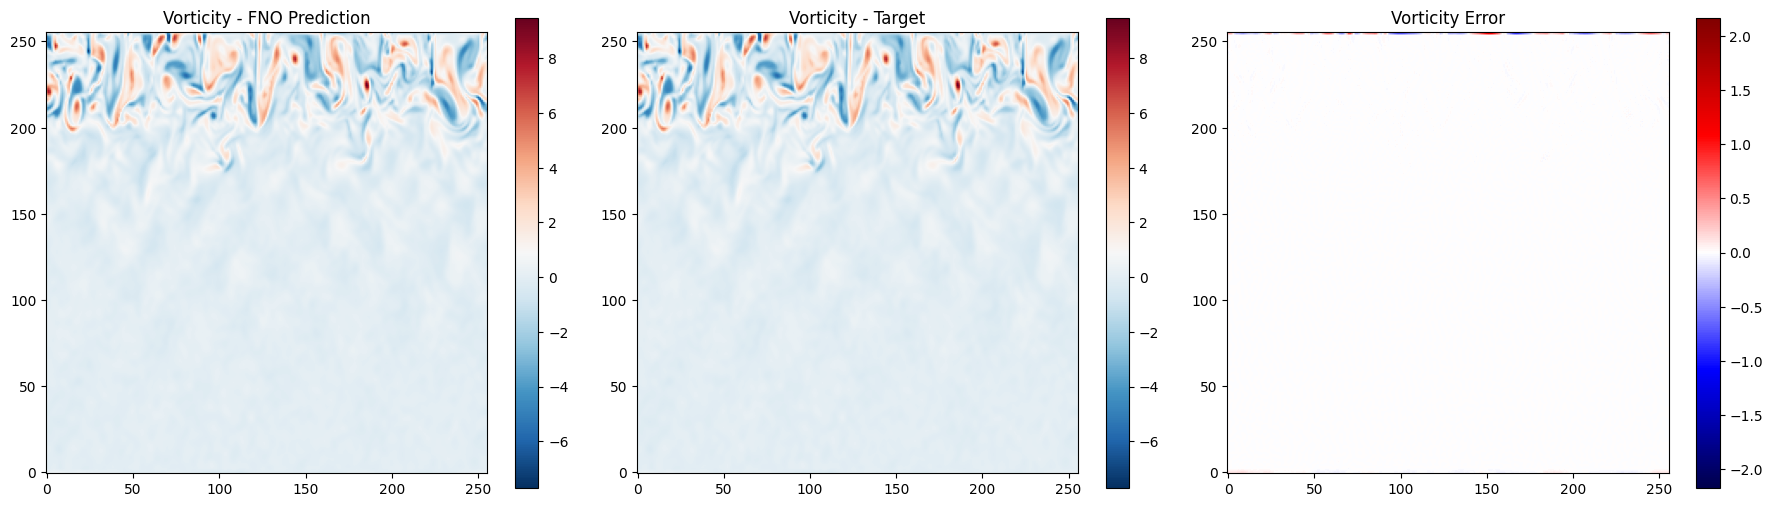

Final best loss: 5.187275


In [6]:
#==================================
# BLOCK 1 - Complete FNO Implementation with All Components
#==================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.fft import rfft2, irfft2
import time

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#==================================
# BLOCK 2 - Core FNO Components
#==================================

class SpectralConv2d(nn.Module):
    """2D Fourier layer. Performs FFT, linear transform, and Inverse FFT."""
    
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to keep in x
        self.modes2 = modes2  # Number of Fourier modes to keep in z
        
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        
    def compl_mul2d(self, input, weights):
        # Complex multiplication
        return torch.einsum("bixy,ioxy->boxy", input, weights)
    
    def forward(self, x):
        batchsize = x.shape[0]
        
        # Compute Fourier coefficients
        x_ft = rfft2(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        # Top-left corner (low frequencies)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        
        # Bottom-left corner (high frequencies in z, low in x)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        
        # Return to physical space
        x = irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNOBlock(nn.Module):
    """Basic FNO block with spectral convolution and skip connection"""
    
    def __init__(self, in_channels, out_channels, modes1, modes2, activation='gelu'):
        super(FNOBlock, self).__init__()
        self.conv = SpectralConv2d(in_channels, out_channels, modes1, modes2)
        self.w = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        
        if activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
    
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.w(x)
        x = self.bn(x1 + x2)
        x = self.activation(x)
        return x

#==================================
# BLOCK 3 - Multi-Variable FNO Model
#==================================

class MultiVariableFNO2d(nn.Module):
    """
    FNO for predicting multiple variables (u, w, b, p) simultaneously
    Takes previous states as input and predicts the next state
    """
    
    def __init__(self, modes1=24, modes2=24, width=64, n_vars=4, n_layers=4):
        super(MultiVariableFNO2d, self).__init__()
        
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_vars = n_vars  # u, w, b, p
        self.n_layers = n_layers
        
        # Input: n_vars channels per time step
        in_channels = n_vars * 3  # 3 time steps
        
        # Input projection
        self.fc0 = nn.Sequential(
            nn.Conv2d(in_channels, width, 1),
            nn.GELU(),
            nn.Conv2d(width, width, 1),
        )
        
        # FNO layers
        self.fno_blocks = nn.ModuleList([
            FNOBlock(width, width, modes1, modes2, activation='gelu')
            for _ in range(n_layers)
        ])
        
        # Output projection for all variables
        self.fc1 = nn.Sequential(
            nn.Conv2d(width, 128, 1),
            nn.GELU(),
            nn.Conv2d(128, 64, 1),
            nn.GELU(),
            nn.Conv2d(64, n_vars, 1)  # Output all variables
        )
        
    def forward(self, x):
        # Lift to higher dimension
        x = self.fc0(x)
        # Apply FNO blocks
        for fno in self.fno_blocks:
            x = fno(x)
        # Project to output (all variables)
        x = self.fc1(x)
        return x

#==================================
# BLOCK 4 - Data Loading and Preprocessing (CORRECTED for Buoyancy)
#==================================

# Load data
ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')

# Select training time steps
train_times = [30, 60, 90]  # Input times
target_time = 120  # Target time to predict

# Fixed time step
dt = 30.0  # Time difference between consecutive snapshots

# Extract fields for all time steps
def extract_fields_at_time(ds, time_idx):
    """Extract all fields at a given time index"""
    data = ds.isel(time=time_idx)
    return {
        'u': data['u'].values,
        'w': data['w'].values,
        'b': data['b'].values,
        'p_dyn': data['p_dyn'].values,
    }

def interpolate_w_to_centers(w_field):
    """Interpolates w from horizontal faces to cell centers."""
    return 0.5 * (w_field[:-1, :] + w_field[1:, :])

def interpolate_to_common_grid(field, target_shape=(256, 256)):
    if field.shape == target_shape:
        return field
    field_tensor = torch.from_numpy(field).float().unsqueeze(0).unsqueeze(0)
    interpolated = F.interpolate(field_tensor, size=target_shape, mode='bilinear', align_corners=True)
    return interpolated.squeeze().numpy()

def normalize_field(field):
    mean = np.mean(field)
    std = np.std(field) + 1e-8
    return (field - mean) / std, mean, std

# Get training data
train_data = [extract_fields_at_time(ds, t) for t in train_times]
target_data = extract_fields_at_time(ds, target_time)

print(f"Training on times: {[t*0.5 for t in train_times]} seconds")
print(f"Predicting time: {target_time*0.5} seconds")

# Process all training data
processed_train_data = []
norm_params = {'u': None, 'w': None, 'b': None, 'p': None, 'b_profile': None}

for i, data in enumerate(train_data):
    processed = {}
    
    w_centered = interpolate_w_to_centers(data['w'])
    u_interp = interpolate_to_common_grid(data['u'])
    b_interp = interpolate_to_common_grid(data['b'])
    p_interp = interpolate_to_common_grid(data['p_dyn'])
    
    # --- CORRECTION: Handle buoyancy background profile ---
    b_profile = np.mean(b_interp, axis=1, keepdims=True)
    b_fluctuations = b_interp - b_profile
    
    if i == 0:
        u_norm, u_mean, u_std = normalize_field(u_interp)
        w_norm, w_mean, w_std = normalize_field(w_centered)
        p_norm, p_mean, p_std = normalize_field(p_interp)
        # Normalize only the fluctuations for buoyancy
        b_norm, b_fluc_mean, b_fluc_std = normalize_field(b_fluctuations)
        
        norm_params['u'] = (u_mean, u_std)
        norm_params['w'] = (w_mean, w_std)
        norm_params['p'] = (p_mean, p_std)
        # Store fluctuation stats and the background profile for buoyancy
        norm_params['b'] = (b_fluc_mean, b_fluc_std)
        norm_params['b_profile'] = b_profile
    else:
        u_norm = (u_interp - norm_params['u'][0]) / norm_params['u'][1]
        w_norm = (w_centered - norm_params['w'][0]) / norm_params['w'][1]
        p_norm = (p_interp - norm_params['p'][0]) / norm_params['p'][1]
        # Normalize fluctuations using stats from the first timestep
        b_fluctuations_norm = (b_fluctuations - norm_params['b'][0]) / norm_params['b'][1]
        b_norm = b_fluctuations_norm

    processed['u'] = u_norm
    processed['w'] = w_norm
    processed['b'] = b_norm
    processed['p'] = p_norm
    
    processed_train_data.append(processed)

# Process target data with the same buoyancy correction
target_b_interp = interpolate_to_common_grid(target_data['b'])
target_b_fluctuations = target_b_interp - norm_params['b_profile']
target_b_norm = (target_b_fluctuations - norm_params['b'][0]) / norm_params['b'][1]

target_w_centered = interpolate_w_to_centers(target_data['w'])
target_processed = {
    'u': (interpolate_to_common_grid(target_data['u']) - norm_params['u'][0]) / norm_params['u'][1],
    'w': (target_w_centered - norm_params['w'][0]) / norm_params['w'][1],
    'b': target_b_norm,
    'p': (interpolate_to_common_grid(target_data['p_dyn']) - norm_params['p'][0]) / norm_params['p'][1]
}

# Stack input data
input_channels = []
for data in processed_train_data:
    input_channels.extend([data['u'], data['w'], data['b'], data['p']])

input_tensor = torch.FloatTensor(np.stack(input_channels, axis=0)).unsqueeze(0).to(device)

# Stack target data
target_tensor = torch.FloatTensor(np.stack([
    target_processed['u'], target_processed['w'], target_processed['b'], target_processed['p']
], axis=0)).unsqueeze(0).to(device)

print(f"Input tensor shape: {input_tensor.shape}")
print(f"Target tensor shape: {target_tensor.shape}")

# Grid parameters
x_coords = ds.x_caa.values
z_coords = ds.z_aac.values
dx = float(x_coords[1] - x_coords[0])
dz = float(z_coords[1] - z_coords[0])
kappa = 1e-6

#==================================
# BLOCK 5 - Physics-Informed Loss Functions (CORRECTED for Buoyancy)
#==================================

def compute_derivatives_multi(fields, dx, dz):
    """Compute spatial derivatives for multiple fields"""
    if fields.dim() == 3:
        fields = fields.unsqueeze(0)
    fields_padded_x = F.pad(fields, (1, 1, 0, 0), mode='circular')
    df_dx = (fields_padded_x[:, :, :, 2:] - fields_padded_x[:, :, :, :-2]) / (2 * dx)
    df_dz = torch.zeros_like(fields)
    df_dz[:, :, 1:-1, :] = (fields[:, :, 2:, :] - fields[:, :, :-2, :]) / (2 * dz)
    df_dz[:, :, 0, :] = (fields[:, :, 1, :] - fields[:, :, 0, :]) / dz
    df_dz[:, :, -1, :] = (fields[:, :, -1, :] - fields[:, :, -2, :]) / dz
    return df_dx, df_dz

def physics_loss_multi(pred_norm, prev_states_norm, dx, dz, dt, kappa, norm_params):
    """Physics loss for multiple variables with corrected buoyancy term."""
    # Denormalize fields, handling buoyancy separately
    u_pred = pred_norm[:, 0] * norm_params['u'][1] + norm_params['u'][0]
    w_pred = pred_norm[:, 1] * norm_params['w'][1] + norm_params['w'][0]
    p_pred = pred_norm[:, 3] * norm_params['p'][1] + norm_params['p'][0]

    # --- CORRECTION: Reconstruct buoyancy field correctly ---
    b_profile_tensor = torch.from_numpy(norm_params['b_profile']).float().to(device)
    b_pred_fluc = pred_norm[:, 2] * norm_params['b'][1] + norm_params['b'][0]
    b_pred = b_pred_fluc + b_profile_tensor

    last_state = prev_states_norm[-1]
    u_last = torch.from_numpy(last_state['u']).float().to(device) * norm_params['u'][1] + norm_params['u'][0]
    w_last = torch.from_numpy(last_state['w']).float().to(device) * norm_params['w'][1] + norm_params['w'][0]
    b_last_fluc = torch.from_numpy(last_state['b']).float().to(device) * norm_params['b'][1] + norm_params['b'][0]
    b_last = b_last_fluc + b_profile_tensor
    
    # Compute derivatives
    all_fields = torch.stack([u_pred, w_pred, b_pred, p_pred], dim=1)
    df_dx, df_dz = compute_derivatives_multi(all_fields, dx, dz)
    
    du_dx, dw_dx, db_dx, dp_dx = [df_dx[:, i] for i in range(4)]
    du_dz, dw_dz, db_dz, dp_dz = [df_dz[:, i] for i in range(4)]
    
    d2u_dx2, _ = compute_derivatives_multi(du_dx.unsqueeze(1), dx, dz); _, d2u_dz2 = compute_derivatives_multi(du_dz.unsqueeze(1), dx, dz)
    d2w_dx2, _ = compute_derivatives_multi(dw_dx.unsqueeze(1), dx, dz); _, d2w_dz2 = compute_derivatives_multi(dw_dz.unsqueeze(1), dx, dz)
    d2b_dx2, _ = compute_derivatives_multi(db_dx.unsqueeze(1), dx, dz); _, d2b_dz2 = compute_derivatives_multi(db_dz.unsqueeze(1), dx, dz)
    
    du_dt, dw_dt, db_dt = (u_pred - u_last) / dt, (w_pred - w_last) / dt, (b_pred - b_last) / dt
    
    u_residual = du_dt + u_pred * du_dx + w_pred * du_dz + dp_dx - kappa * (d2u_dx2.squeeze(1) + d2u_dz2.squeeze(1))
    w_residual = dw_dt + u_pred * dw_dx + w_pred * dw_dz + dp_dz - kappa * (d2w_dx2.squeeze(1) + d2w_dz2.squeeze(1)) + b_pred
    continuity_residual = du_dx + dw_dz
    b_residual = db_dt + u_pred * db_dx + w_pred * db_dz - kappa * (d2b_dx2.squeeze(1) + d2b_dz2.squeeze(1))
    
    loss = (torch.mean(u_residual**2) + torch.mean(w_residual**2) + torch.mean(continuity_residual**2) + torch.mean(b_residual**2))
    return loss

def boundary_loss_multi(pred_norm, norm_params):
    """Boundary condition loss for all variables."""
    u_pred = pred_norm[:, 0] * norm_params['u'][1] + norm_params['u'][0]
    w_pred = pred_norm[:, 1] * norm_params['w'][1] + norm_params['w'][0]
    
    # --- CORRECTION: Reconstruct buoyancy for BC loss ---
    b_profile_tensor = torch.from_numpy(norm_params['b_profile']).float().to(device)
    b_pred_fluc = pred_norm[:, 2] * norm_params['b'][1] + norm_params['b'][0]
    b_pred = b_pred_fluc + b_profile_tensor
    
    u_bc = torch.mean(u_pred[:, -1, :]**2) + torch.mean(u_pred[:, 0, :]**2)
    w_bc = torch.mean(w_pred[:, -1, :]**2) + torch.mean(w_pred[:, 0, :]**2)
    b_bc = torch.mean((b_pred[:, -1, :] - 0.5)**2) + torch.mean((b_pred[:, 0, :] - 0.0)**2)
    
    return u_bc + w_bc + b_bc

def smoothness_loss_multi(pred):
    """Total variation regularization for all variables"""
    tv_loss = 0
    for i in range(pred.shape[1]):
        field = pred[:, i]
        tv_z = torch.mean(torch.abs(field[:, 1:, :] - field[:, :-1, :]))
        tv_x = torch.mean(torch.abs(field[:, :, 1:] - field[:, :, :-1]))
        tv_loss += tv_z + tv_x
    return tv_loss

#==================================
# BLOCK 6 - Model Initialization and Training Setup
#==================================

model = MultiVariableFNO2d(modes1=32, modes2=32, width=64, n_vars=4, n_layers=4).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in Multi-Variable FNO: {total_params:,}")

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=2000, steps_per_epoch=1, pct_start=0.1, anneal_strategy='cos')
loss_weights = {'physics': 1.0, 'bc': 50.0, 'data': 10.0, 'smooth': 0.01}

#==================================
# BLOCK 7 - Training Loop
#==================================

history = {'total_loss': [], 'physics_loss': [], 'bc_loss': [], 'data_loss': [], 'smooth_loss': []}
model.train()
n_epochs = 2000
print_interval = 100
print("\nStarting Multi-Variable FNO training with corrected physics and normalization...")
best_loss = float('inf')
start_time = time.time()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    pred_norm = model(input_tensor)
    l_physics = physics_loss_multi(pred_norm, processed_train_data, dx, dz, dt, kappa, norm_params)
    l_bc = boundary_loss_multi(pred_norm, norm_params)
    l_data = torch.mean((pred_norm - target_tensor)**2)
    l_smooth = smoothness_loss_multi(pred_norm)
    total_loss = (loss_weights['physics'] * l_physics + loss_weights['bc'] * l_bc + loss_weights['data'] * l_data + loss_weights['smooth'] * l_smooth)
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    
    history['total_loss'].append(total_loss.item())
    history['physics_loss'].append(l_physics.item())
    history['bc_loss'].append(l_bc.item())
    history['data_loss'].append(l_data.item())
    history['smooth_loss'].append(l_smooth.item())
    
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        best_model_state = model.state_dict().copy()
    
    if epoch % print_interval == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch}/{n_epochs} | Total: {total_loss.item():.6f} | "
              f"Physics: {l_physics.item():.6f} | BC: {l_bc.item():.6f} | "
              f"Data: {l_data.item():.6f} | LR: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nTraining completed in {time.time() - start_time:.2f} seconds.")
model.load_state_dict(best_model_state)

#==================================
# BLOCK 8 - Plot Training History
#==================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
loss_names = ['total_loss', 'physics_loss', 'bc_loss', 'data_loss', 'smooth_loss']
loss_titles = ['Total Loss', 'Physics Loss', 'BC Loss', 'Data Loss', 'Smoothness Loss']
for idx, (loss_name, title) in enumerate(zip(loss_names, loss_titles)):
    ax = axes[idx]
    ax.semilogy(history[loss_name])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

ax = axes[5]
plot_optimizer = optim.AdamW(model.parameters(), lr=1e-3)
plot_scheduler = optim.lr_scheduler.OneCycleLR(plot_optimizer, max_lr=1e-3, epochs=n_epochs, steps_per_epoch=1)
lrs = []
for i in range(n_epochs):
    lrs.append(plot_scheduler.get_last_lr()[0])
    plot_scheduler.step()
ax.plot(lrs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#==================================
# BLOCK 9 - Evaluation and Visualization (CORRECTED for Buoyancy)
#==================================

model.eval()
with torch.no_grad():
    pred_norm = model(input_tensor)
    pred_norm = pred_norm.squeeze().cpu().numpy()

# --- CORRECTION: Reconstruct buoyancy field correctly for evaluation ---
b_pred_fluc = pred_norm[2] * norm_params['b'][1] + norm_params['b'][0]
b_pred_reconstructed = b_pred_fluc + norm_params['b_profile']

predictions = {
    'u': pred_norm[0] * norm_params['u'][1] + norm_params['u'][0],
    'w': pred_norm[1] * norm_params['w'][1] + norm_params['w'][0],
    'b': b_pred_reconstructed,
    'p': pred_norm[3] * norm_params['p'][1] + norm_params['p'][0]
}

targets = {
    'u': interpolate_to_common_grid(target_data['u']),
    'w': interpolate_w_to_centers(target_data['w']),
    'b': interpolate_to_common_grid(target_data['b']),
    'p': interpolate_to_common_grid(target_data['p_dyn'])
}

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle(f'FNO Prediction vs. Target at t={target_time*0.5}s', fontsize=16)
variables = ['u', 'w', 'b', 'p']
var_names = ['Horizontal Velocity (u)', 'Vertical Velocity (w)', 'Buoyancy (b)', 'Pressure (p)']

for i, (var, var_name) in enumerate(zip(variables, var_names)):
    pred = predictions[var]
    target = targets[var]
    vmin = min(pred.min(), target.min())
    vmax = max(pred.max(), target.max())
    
    im1 = axes[i, 0].imshow(pred, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
    axes[i, 0].set_title(f'{var_name} - Prediction')
    fig.colorbar(im1, ax=axes[i, 0])
    
    im2 = axes[i, 1].imshow(target, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
    axes[i, 1].set_title(f'{var_name} - Target')
    fig.colorbar(im2, ax=axes[i, 1])
    
    diff = pred - target
    diff_max = np.abs(diff).max()
    im3 = axes[i, 2].imshow(diff, aspect='equal', cmap='seismic', vmin=-diff_max, vmax=diff_max, origin='lower')
    axes[i, 2].set_title(f'{var_name} - Error')
    fig.colorbar(im3, ax=axes[i, 2])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

print("\nError Metrics for All Variables:")
print("-" * 50)
for var, var_name in zip(variables, var_names):
    pred = predictions[var]
    target = targets[var]
    mse = np.mean((pred - target)**2)
    mae = np.mean(np.abs(pred - target))
    max_error = np.max(np.abs(pred - target))
    rel_error = np.mean(np.abs(pred - target) / (np.abs(target) + 1e-8))
    print(f"\n{var_name}:\n  MSE: {mse:.6f}\n  MAE: {mae:.6f}\n  Max Error: {max_error:.6f}\n  Relative Error: {rel_error:.4%}")

def compute_energy_enstrophy(u, w, dx, dz):
    ke = 0.5 * (u**2 + w**2)
    total_ke = np.mean(ke)
    du_dz = np.gradient(u, dz, axis=0)
    dw_dx = np.gradient(w, dx, axis=1)
    vorticity = dw_dx - du_dz
    enstrophy = 0.5 * vorticity**2
    total_enstrophy = np.mean(enstrophy)
    return total_ke, total_enstrophy, vorticity

ke_pred, ens_pred, vort_pred = compute_energy_enstrophy(predictions['u'], predictions['w'], dx, dz)
ke_target, ens_target, vort_target = compute_energy_enstrophy(targets['u'], targets['w'], dx, dz)
print("\n" + "="*50 + "\nIntegral Quantities:\n" + "-"*50)
print(f"Kinetic Energy - Predicted: {ke_pred:.6f}, Target: {ke_target:.6f}, Error: {abs(ke_pred - ke_target)/ke_target:.2%}")
print(f"Enstrophy      - Predicted: {ens_pred:.6f}, Target: {ens_target:.6f}, Error: {abs(ens_pred - ens_target)/ens_target:.2%}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
vmin = min(vort_pred.min(), vort_target.min())
vmax = max(vort_pred.max(), vort_target.max())
im1 = axes[0].imshow(vort_pred, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[0].set_title('Vorticity - FNO Prediction')
plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(vort_target, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[1].set_title('Vorticity - Target')
plt.colorbar(im2, ax=axes[1])
diff_vort = vort_pred - vort_target
im3 = axes[2].imshow(diff_vort, aspect='equal', cmap='seismic', vmin=-np.abs(diff_vort).max(), vmax=np.abs(diff_vort).max(), origin='lower')
axes[2].set_title('Vorticity Error')
plt.colorbar(im3, ax=axes[2])
plt.tight_layout()
plt.show()

#==================================
# BLOCK 10 - Save Model
#==================================

# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'norm_params': norm_params,
#     'loss_history': history,
# }, 'multi_variable_fno_model_corrected.pth')
# print("\nCorrected model saved successfully!")
print(f"Final best loss: {best_loss:.6f}")
